In [226]:
import pandas as pd
import json
import requests
import numpy as np
import matplotlib.pyplot as plt

In [227]:
test = pd.ExcelFile('struktura_ludnosci.xls')
test = test.parse(0)
test = test.drop([0, 1, 2, 4])
test = test.transpose()
test = test.reset_index()
test = test.drop(columns=['index'])
test.columns = test.iloc[0]
test.drop(index=0, inplace=True)
test = test.set_index('Grupy wieku')
test.index.names = ['Rok']
test.index = test.index.astype(np.int64)
test = test.loc[:, :'Kobiety w wieku rozrodczym 15 - 49 lat          ']
test = test.drop(['OGÓŁEM', ' 0 - 14', ' 15 - 64', '     w tym:', ' 18 - 44', '     w tym: 18', ' 60/65 lat i więcej', ' 18 -59/64'], axis=1)

In [228]:
test.columns

Index([' 0 - 2 lata', ' 3 -6', ' 7 - 14', ' 15 - 18', ' 19 - 24', ' 0 - 17',
       ' 45 - 59/64', ' 65 lat i więcej',
       'Kobiety w wieku rozrodczym 15 - 49 lat          '],
      dtype='object', name=0)

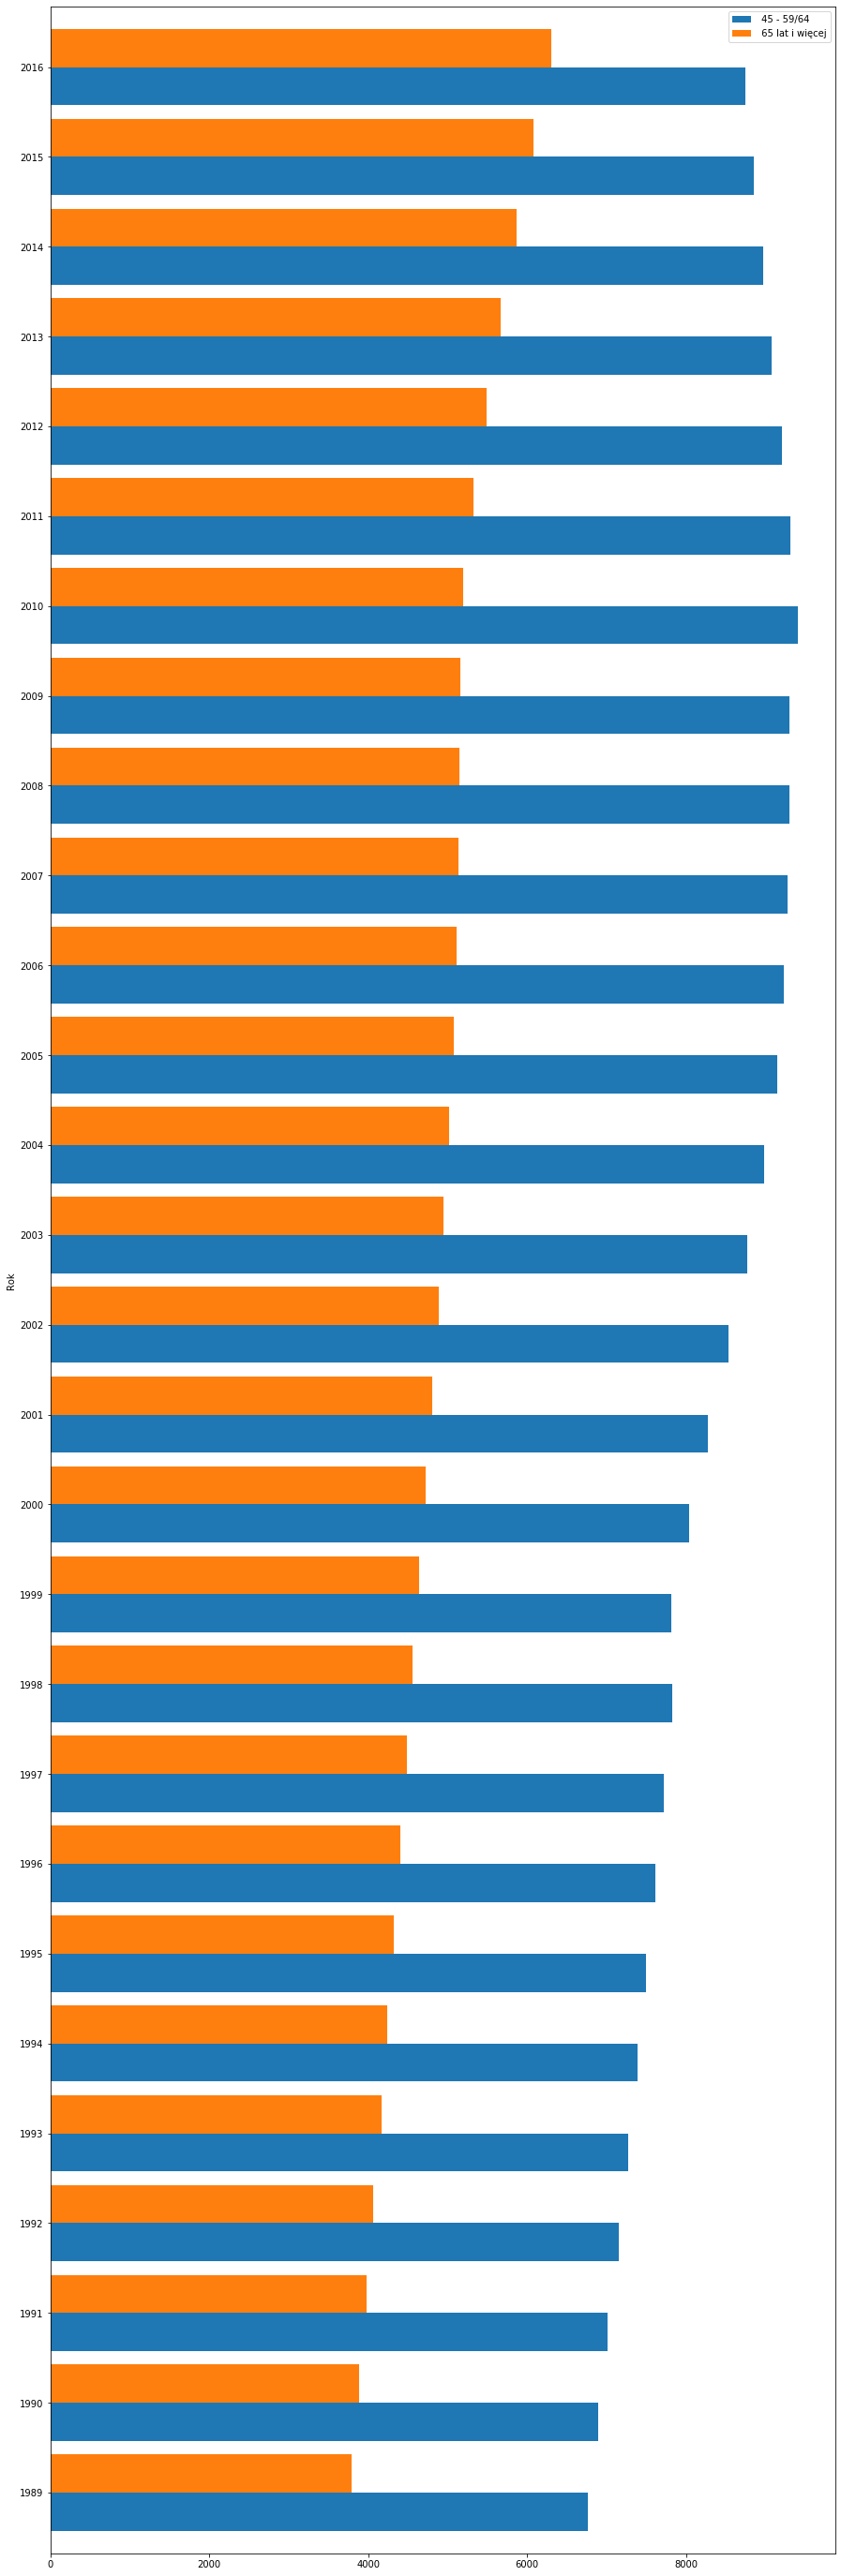

In [230]:
test.loc[:, [' 45 - 59/64', ' 65 lat i więcej']].plot(kind='barh', figsize=(15, 50), width=0.85);
plt.legend(loc='best')
# fig, ax = plt.subplots()

# ax.bar(test.index, test.iloc[0, 1])
# ax.bar(test.index, test.iloc[0, 2])
# for i in range(len(test.index)):
#     for j in range(len(test.columns))

In [181]:
test

,OGÓŁEM,0 - 2 lata,3 -6,7 - 14,15 - 18,w tym: 18,19 - 24,0 - 17,18 -59/64,w tym:,18 - 44,45 - 59/64,60/65 lat i więcej,0 - 14,15 - 64,65 lat i więcej,Kobiety w wieku rozrodczym 15 - 49 lat
Rok,,,,,,,,,,,,,,,,,
1989,37988,1739,2664,5093,2248,536,3049,11208,21983,NaN,15220,6763,4798,9495,24697,3796,9354
1990,38073,1670,2584,5042,2297,550,3125,11043,22146,NaN,15255,6890,4884,9296,24891,3887,9442
1991,38144,1629,2478,4987,2342,562,3194,10873,22303,NaN,15289,7015,4968,9094,25075,3975,9526
1992,38203,1581,2366,4930,2385,575,3261,10688,22458,NaN,15304,7154,5057,8877,25258,4068,9601
1993,38239,1531,2264,4869,2428,587,3328,10504,22583,NaN,15308,7274,5153,8663,25407,4169,9669
1994,38265,1467,2202,4807,2470,599,3393,10346,22700,NaN,15309,7391,5219,8476,25548,4242,9734
1995,38284,1388,2131,4763,2509,610,3456,10180,22809,NaN,15307,7503,5295,8281,25679,4324,9795
1996,38294,1324,2064,4699,2552,623,3523,10016,22914,NaN,15301,7613,5364,8087,25805,4402,9866
1997,38290,1259,2001,4627,2592,634,3585,9845,23006,NaN,15289,7717,5439,7887,25919,4484,9931


Wartości powyżej są w tysiącach

In [182]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Fixing random state for reproducibility
np.random.seed(19680801)


def gen_rand_line(length, dims=2):
    """
    Create a line using a random walk algorithm.

    Parameters
    ----------
    length : int
        The number of points of the line.
    dims : int
        The number of dimensions of the line.
    """
    line_data = np.empty((dims, length))
    line_data[:, 0] = np.random.rand(dims)
    for index in range(1, length):
        # scaling the random numbers by 0.1 so
        # movement is small compared to position.
        # subtraction by 0.5 is to change the range to [-0.5, 0.5]
        # to allow a line to move backwards.
        step = (np.random.rand(dims) - 0.5) * 0.1
        line_data[:, index] = line_data[:, index - 1] + step
    return line_data


def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
    return lines


# Attaching 3D axis to the figure
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Fifty lines of random 3-D lines
data = [gen_rand_line(25, 3) for index in range(50)]

# Creating fifty line objects.
# NOTE: Can't pass empty arrays into 3d version of plot()
lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1])[0] for dat in data]

# Setting the axes properties
ax.set_xlim3d([0.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([0.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 1.0])
ax.set_zlabel('Z')

ax.set_title('3D Test')

# Creating the Animation object
line_ani = animation.FuncAnimation(
    fig, update_lines, 25, fargs=(data, lines), interval=50)

plt.show()

ValueError: Unknown projection '3d'

<Figure size 432x288 with 0 Axes>